In [ ]:
import os
import sys
sys.path.insert(0, os.path.abspath(".."))
from models import UNetDiffusion, UNet_diffusion_normal, UNet_diffusion_mvnormal
import torch
from models import DistributionalDiffusion
import matplotlib.pyplot as plt
from data import PDE1D
import matplotlib.pyplot as plt
from torch.distributions.lowrank_multivariate_normal import LowRankMultivariateNormal
from torch.distributions.multivariate_normal import MultivariateNormal
import scienceplots

from cmap import Colormap
plt.rcParams['image.cmap']= 'cividis'
device = "cuda"

torch.set_grad_enabled(False)

In [2]:
torch.manual_seed(3)
test_dataset = PDE1D(
    data_dir="../data/",
    pde="KS",
    var="test",
    downscaling_factor=1,
    normalize=True,
    last_t_steps=2,
    temporal_downscaling_factor=2,
    select_timesteps="random"
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=True,
    num_workers=0,
)

target_dim, input_dim = (
    (1, *test_dataset.get_dimensions()),
    (3, *test_dataset.get_dimensions()),
)
grid = test_dataset.get_coordinates()[0]

In [3]:
cfg_scale = 0
x_T_sampling_method="standard"
n_timesteps = 50
n_samples = 25
t_steps = 50
ddim_churn = 1.0
noise_schedule = "linear"

In [4]:
idx = 20
target, input = test_dataset[idx]
target = target.to(device).unsqueeze(0)
input = input.to(device).unsqueeze(0)

# Normal

In [5]:
ckpt_path = "../results/KS/normal/Datetime_20250831_213836_Loss_1D_KS_UNet_diffusion_normal_T50_DDIM1.pt"
distributional_method = "normal"
beta_endpoints=(0.001, 0.2)

In [6]:
backbone =  UNetDiffusion(
            d=1,
            conditioning_dim=3,
            hidden_channels=64,
            in_channels=1,
            out_channels=1,
            init_features=64,
            domain_dim = target_dim
        )

model = UNet_diffusion_normal(
    backbone=backbone,
    d=1,
    target_dim = 1,
)
model.load_state_dict(
    torch.load(ckpt_path, map_location=device)
)
model = model.to(device)


/tmp/ipykernel_794101/467673265.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(ckpt_path, map_location=device)


In [7]:
torch.manual_seed(3)
diffusion = DistributionalDiffusion(
    noise_steps=n_timesteps,
    img_size=target_dim,
    device=device,
    ddim_churn=ddim_churn,
    distributional_method=distributional_method,
    x_T_sampling_method=x_T_sampling_method,
    noise_schedule=noise_schedule,
    beta_endpoints=beta_endpoints,
)

n = input.shape[0]
pred = None
conditioning = input

In [8]:
timestep_array = torch.zeros(n_timesteps -1, *target.shape)

In [9]:
x = diffusion.sample_x_T((n, *diffusion.img_size), pred, inference=True)
for step, i in enumerate(reversed(range(1, diffusion.noise_steps))):                
    t = (torch.ones(n) * i).long().to(diffusion.device)
    predicted_noise = diffusion.sample_noise(model, x, t, conditioning, pred)
    # Generate prediction
    mu_sigma_pred = model(x, t, conditioning, pred = pred)
    _, sigma = torch.split(mu_sigma_pred, 1, -1)
    timestep_array[step] = sigma.squeeze(-1)

    x = diffusion.sample_x_t_inference_DDIM(x, t, predicted_noise, pred, i)

In [10]:
normal_cov = torch.diag_embed(timestep_array.squeeze(2), dim1 = -1, dim2 = -2).squeeze().cpu()
std = torch.sqrt(torch.diagonal(normal_cov, dim1=-2, dim2=-1))  # [B, D]
normal_corr = normal_cov / (std.unsqueeze(-1) * std.unsqueeze(-2)) 

# LoRa (R=1)

In [11]:
ckpt_path = "../results/KS/mvnormal/Datetime_20250901_160327_Loss_1D_KS_UNet_diffusion_mvnormal_T50_DDIM1.pt"
distributional_method = "mvnormal"
beta_endpoints=(0.001, 0.35)

In [12]:
backbone =  UNetDiffusion(
            d=1,
            conditioning_dim=3,
            hidden_channels=64,
            in_channels=1,
            out_channels=1,
            init_features=64,
            domain_dim = target_dim
        )


model = UNet_diffusion_mvnormal(
    backbone=backbone,
    d=1,
    target_dim = 1,
    domain_dim = target_dim[1:],
    rank = 1,
    method = "lora"
)

dict = torch.load(ckpt_path, map_location=device)
model.load_state_dict(dict
    
)
model = model.to(device)


/tmp/ipykernel_794101/1983300187.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dict = torch.load(ckpt_path, map_location=device)


In [13]:
torch.manual_seed(3)
diffusion = DistributionalDiffusion(
    noise_steps=n_timesteps,
    img_size=target_dim,
    device=device,
    ddim_churn=ddim_churn,
    distributional_method=distributional_method,
    x_T_sampling_method=x_T_sampling_method,
    noise_schedule=noise_schedule,
    beta_endpoints=beta_endpoints,
)

n = input.shape[0]
pred = None
conditioning = input

In [14]:
timestep_array = torch.zeros(n_timesteps -1, *target.shape, target.shape[-1]).squeeze()
timestep_array.shape

torch.Size([49, 256, 256])

In [15]:
x = diffusion.sample_x_T((n, *diffusion.img_size), pred, inference=True)
for step, i in enumerate(reversed(range(1, diffusion.noise_steps))):                
    t = (torch.ones(n) * i).long().to(diffusion.device)
    predicted_noise = diffusion.sample_noise(model, x, t, conditioning, pred)
    # Generate prediction
    mu_sigma_pred = model(x, t, conditioning, pred = pred)
    mu = mu_sigma_pred[...,0]
    diag = mu_sigma_pred[...,1]
    lora = mu_sigma_pred[...,2:]
    mvnorm = LowRankMultivariateNormal(mu, lora, diag)
    timestep_array[step] = mvnorm.covariance_matrix.squeeze(1)

    x = diffusion.sample_x_t_inference_DDIM(x, t, predicted_noise, pred, i)

In [16]:
std = torch.sqrt(torch.diagonal(timestep_array, dim1=-2, dim2=-1))  # [B, D]
mvnormal_cov_1 = timestep_array
mvnormal_corr_1 = mvnormal_cov_1 / (std.unsqueeze(-1) * std.unsqueeze(-2)) 

# LoRa (R=50)

In [17]:
ckpt_path = "../results/20250915_133621_debug/Datetime_20250915_133644_Loss_1D_KS_UNet_diffusion_mvnormal_T50_DDIM1.pt"
distributional_method = "mvnormal"

In [18]:
backbone =  UNetDiffusion(
            d=1,
            conditioning_dim=3,
            hidden_channels=64,
            in_channels=1,
            out_channels=1,
            init_features=64,
            domain_dim = target_dim
        )


model = UNet_diffusion_mvnormal(
    backbone=backbone,
    d=1,
    target_dim = 1,
    domain_dim = target_dim[1:],
    rank = 50,
    method = "lora"
)

dict = torch.load(ckpt_path, map_location=device)
model.load_state_dict(dict
    
)
model = model.to(device)


/tmp/ipykernel_794101/969112621.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dict = torch.load(ckpt_path, map_location=device)


In [19]:
diffusion = DistributionalDiffusion(
    noise_steps=n_timesteps,
    img_size=target_dim,
    device=device,
    ddim_churn=ddim_churn,
    distributional_method=distributional_method,
    x_T_sampling_method=x_T_sampling_method,
    noise_schedule=noise_schedule,
    beta_endpoints=beta_endpoints,
)

n = input.shape[0]
pred = None
conditioning = input

In [20]:
timestep_array = torch.zeros(n_timesteps -1, *target.shape, target.shape[-1]).squeeze()
timestep_array.shape

torch.Size([49, 256, 256])

In [21]:
x = diffusion.sample_x_T((n, *diffusion.img_size), pred, inference=True)
for step, i in enumerate(reversed(range(1, diffusion.noise_steps))):                
    t = (torch.ones(n) * i).long().to(diffusion.device)
    predicted_noise = diffusion.sample_noise(model, x, t, conditioning, pred)
    # Generate prediction
    mu_sigma_pred = model(x, t, conditioning, pred = pred)
    mu = mu_sigma_pred[...,0]
    diag = mu_sigma_pred[...,1]
    lora = mu_sigma_pred[...,2:]
    mvnorm = LowRankMultivariateNormal(mu, lora, diag)
    timestep_array[step] = mvnorm.covariance_matrix.squeeze(1)

    x = diffusion.sample_x_t_inference_DDIM(x, t, predicted_noise, pred, i)

In [22]:
std = torch.sqrt(torch.diagonal(timestep_array, dim1=-2, dim2=-1))  # [B, D]
mvnormal_cov_50 = timestep_array
mvnormal_corr_50 = mvnormal_cov_50 / (std.unsqueeze(-1) * std.unsqueeze(-2)) 

# Multivariate normal (Cholesky)

In [23]:
ckpt_path = "../results/20250915_133843_debug/Datetime_20250915_133859_Loss_1D_KS_UNet_diffusion_mvnormal_T50_DDIM1.pt"
distributional_method = "mvnormal"

In [24]:
backbone =  UNetDiffusion(
            d=1,
            conditioning_dim=3,
            hidden_channels=64,
            in_channels=1,
            out_channels=1,
            init_features=64,
            domain_dim = target_dim
        )


model = UNet_diffusion_mvnormal(
    backbone=backbone,
    d=1,
    target_dim = 1,
    domain_dim = target_dim[1:],
    rank = 10,
    method = "cholesky"
)

dict = torch.load(ckpt_path, map_location=device)
model.load_state_dict(dict
    
)
model = model.to(device)


/tmp/ipykernel_794101/2497970502.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dict = torch.load(ckpt_path, map_location=device)


In [25]:
diffusion = DistributionalDiffusion(
    noise_steps=n_timesteps,
    img_size=target_dim,
    device=device,
    ddim_churn=ddim_churn,
    distributional_method=distributional_method,
    x_T_sampling_method=x_T_sampling_method,
    noise_schedule=noise_schedule,
    beta_endpoints=beta_endpoints,
)

n = input.shape[0]
pred = None
conditioning = input

In [26]:
timestep_array = torch.zeros(n_timesteps -1, *target.shape, target.shape[-1]).squeeze()
timestep_array.shape

torch.Size([49, 256, 256])

In [27]:
x = diffusion.sample_x_T((n, *diffusion.img_size), pred, inference=True)
for step, i in enumerate(reversed(range(1, diffusion.noise_steps))):                
    t = (torch.ones(n) * i).long().to(diffusion.device)
    predicted_noise = diffusion.sample_noise(model, x, t, conditioning, pred)
    # Generate prediction
    mu_sigma_pred = model(x, t, conditioning, pred = pred)
    mu = mu_sigma_pred[...,0]
    L = mu_sigma_pred[...,1:]
    mvnorm = MultivariateNormal(mu, scale_tril=L)
    timestep_array[step] = mvnorm.covariance_matrix.squeeze(1)

    x = diffusion.sample_x_t_inference_DDIM(x, t, predicted_noise, pred, i)

In [28]:
std = torch.sqrt(torch.diagonal(timestep_array, dim1=-2, dim2=-1))  # [B, D]
mvnormal_cholesky_cov = timestep_array
mvnormal_cholesky_corr = mvnormal_cholesky_cov / (std.unsqueeze(-1) * std.unsqueeze(-2))

# Plots

In [29]:
ticksize = 29
legendsize = 32
axissize = 31
titlesize = 34
plt.style.use(["science"])
cmap = Colormap('seaborn:icefire').to_mpl()

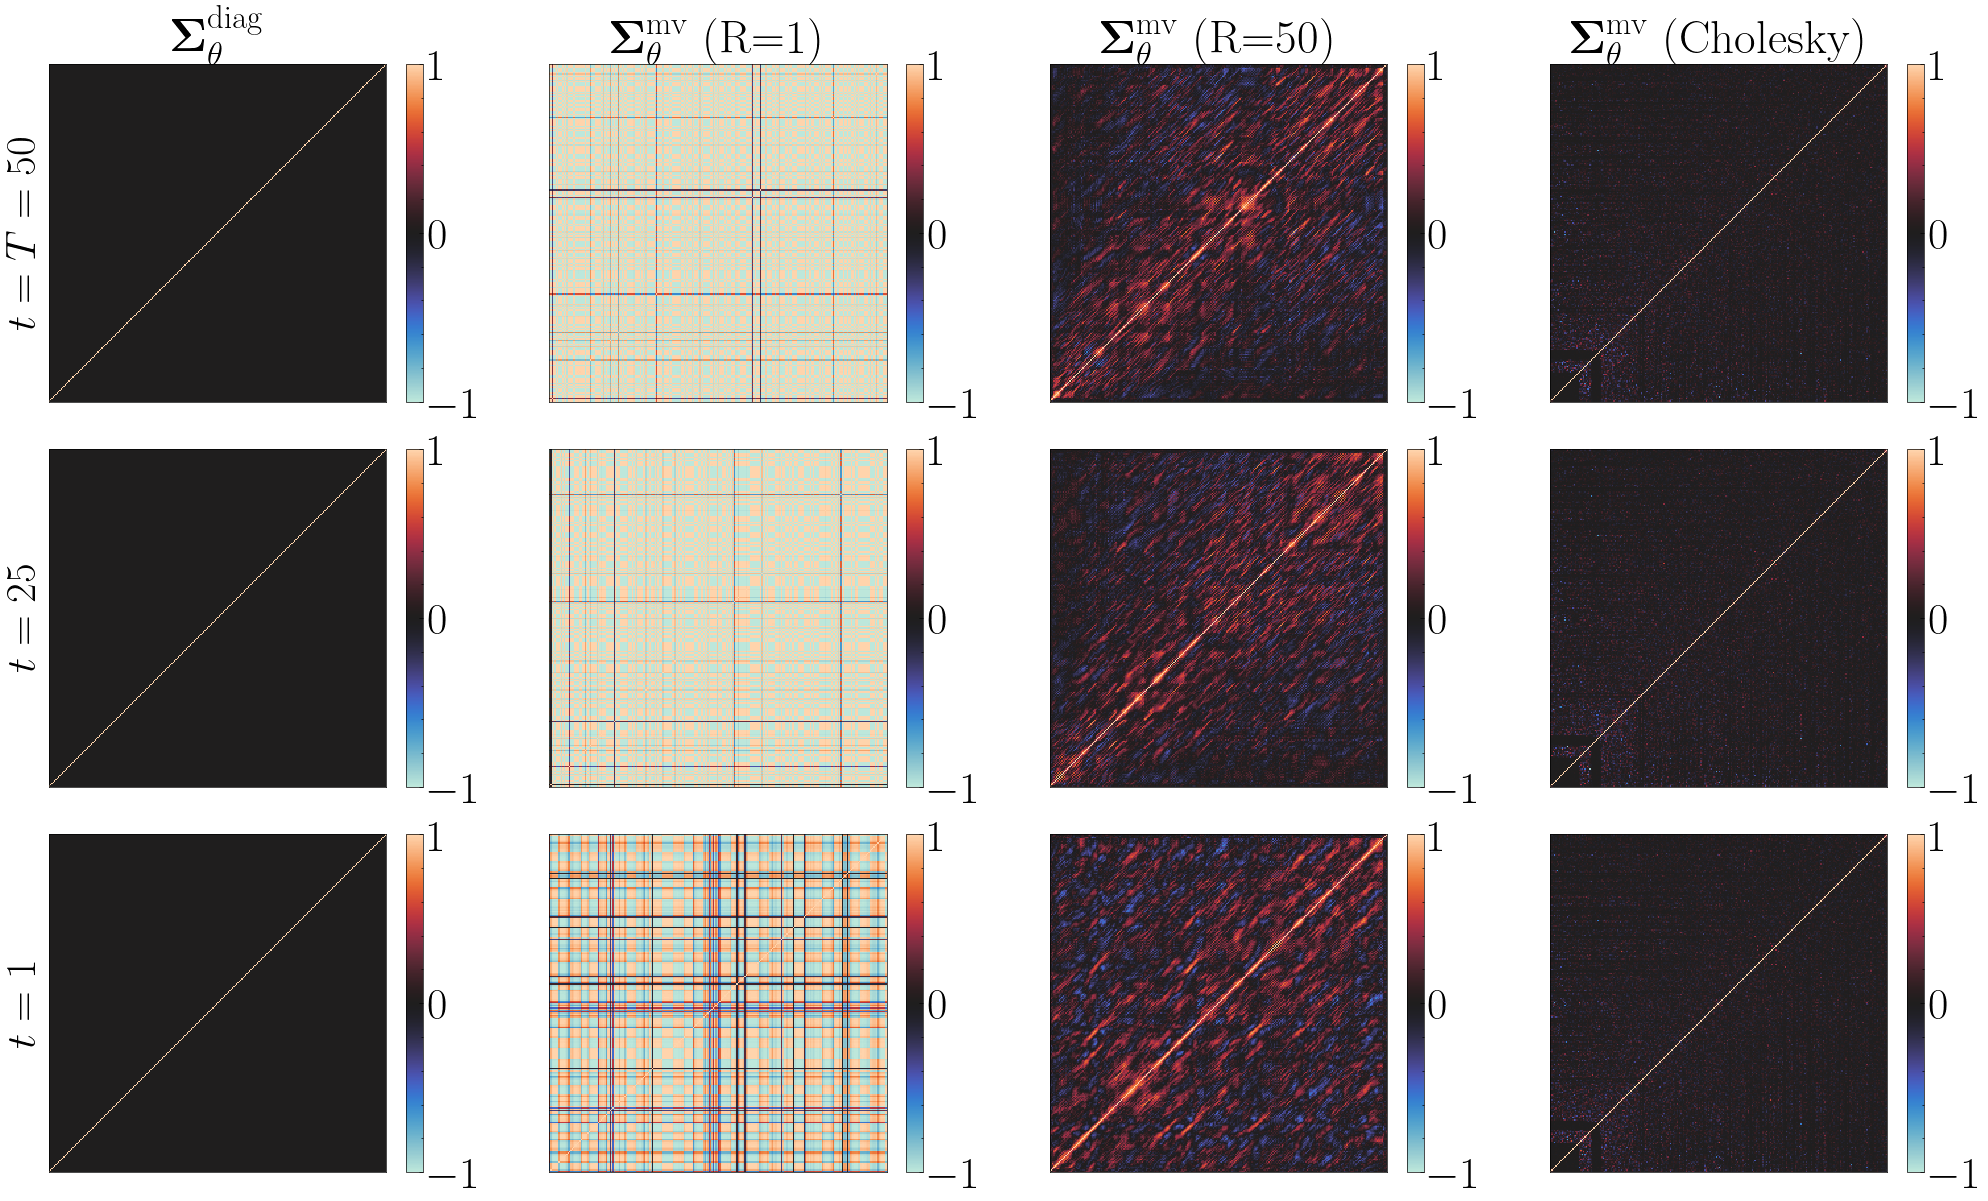

In [30]:
steps = [0, 25, 48]
methods = [
    (r"$\boldsymbol{\Sigma}_\theta^\mathrm{diag}$", normal_corr),
    (r"$\boldsymbol{\Sigma}_\theta^\mathrm{mv}$ (R=1)", mvnormal_corr_1),
    (r"$\boldsymbol{\Sigma}_\theta^\mathrm{mv}$ (R=50)", mvnormal_corr_50),
    (r"$\boldsymbol{\Sigma}_\theta^\mathrm{mv}$ (Cholesky)", mvnormal_cholesky_corr),
]

n_rows = len(steps)
n_cols = len(methods)
cbs = []

fig, axs = plt.subplots(
    n_rows, n_cols, figsize=(20, 12),
    sharex=True, sharey=True,
    layout="constrained", subplot_kw={"aspect":1}
)

# Loop over steps (rows) and methods (cols)
for i, step in enumerate(steps):
    for j, (label, data) in enumerate(methods):
        im = axs[i, j].pcolormesh(data[step], rasterized = True, cmap = cmap, vmin = -1, vmax = 1)
        cbs.append(plt.colorbar(im, ax=axs[i, j]))


for i in range(n_rows):
    for j in range(1, n_cols):
        axs[i, j].set_yticks([])
for i in range(n_rows-1):
    for j in range(n_cols):
        axs[i, j].set_xticks([])

# Column titles = methods
for j, (label, _) in enumerate(methods):
    axs[0, j].set_title(label, fontsize = titlesize)

for cb in cbs:
    cb.ax.tick_params(labelsize=legendsize)


axs[0,0].set_ylabel(r"$t = T = 50$", fontsize = axissize)
axs[1,0].set_ylabel(r"$t = 25$", fontsize = axissize)
axs[2,0].set_ylabel(r"$t = 1$", fontsize = axissize)

plt.savefig(f"plots/KS_correlation_example.pdf", bbox_inches = "tight")